In [1]:
import numpy as np
import torch
import secrets
import random
import importlib
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Import the simple_example module, reloading it so we are sure to get any changes.

In [2]:
import simple_example
importlib.reload(simple_example)

<module 'simple_example' from '/Users/timothybretl/Documents/courses/598RL/02_Fall2020/598rl-fa20/lecture_notes/13_actorcritic/simple_example.py'>

Seed all possible random number generators.

In [3]:
# Get 32 random bits to use as a common seed
seed = secrets.randbits(32)

# Seed the default random number generator
random.seed(seed)

# Seed the classical numpy random number generator
np.random.seed(seed)

# Create an instance of and seed the modern numpy random number generator
rg = np.random.default_rng(seed)

# Seed the torch random number generator
torch.manual_seed(seed)

Create an instance of the simple example environment

In [4]:
env = simple_example.SimpleExample(rg=rg)

Unit test to check for valid model of initial probability and transition probability

In [5]:
for s in [0, 1]:
    for a in [0, 1]:
        p = 0
        for s_prime in [0, 1]:
            for done in [True, False]:
                p += env.p(s_prime, s, a, done=done)
        if not np.isclose(p, 1):
            raise Exception(f'p = {p} should be 1 for (s, a) = ({s}, {a})')

What we need to compute the exact payoff and the exact gradient of payoff with respect to $\theta$.

In [6]:
def action_probability(a, s, theta):
    return np.exp(theta[s, a]) / np.exp(theta[s]).sum()

def action_probabilities(s, theta):
    return np.exp(theta[s]) / np.exp(theta[s]).sum()

def trajectory_probability(tau, theta):
    # tau = [s0, a0, s1, a1, ..., aT-1, sT]
    T = len(tau) // 2
    p = env.p0(tau[0])
    for t in range(T):
        s = tau[2 * t]
        a = tau[2 * t + 1]
        s_prime = tau[2 * t + 2]
        p *= action_probability(a, s, theta)
        p *= env.p(s_prime, s, a, done=(t == (T - 1)))
    return p

def total_reward(tau):
    # tau = [s0, a0, s1, a1, ..., aT-1, sT]
    T = len(tau) // 2
    r = 0
    for step in range(T):
        s = tau[2 * step]
        a = tau[2 * step + 1]
        s_prime = tau[2 * step + 2]
        r += env.r(s, a, s_prime)
    return r

def payoff(theta, max_num_steps):
    J = 0
    for num_steps in range(1, max_num_steps):
        for tau in itertools.product(*[[0, 1] for step in range(2 * num_steps + 1)]):
            J += total_reward(tau) * trajectory_probability(tau, theta)
    return J

def action_log_probability(a, s, theta):
    return theta[s, a] - np.log(np.exp(theta[s]).sum())

def action_log_probability_gradient(a, s, theta):
    grad = np.zeros_like(theta)
    grad[s, a] += 1
    grad[s] -= action_probabilities(s, theta)
    return grad

def trajectory_log_probability_gradient(tau, theta):
    # tau = [s0, a0, s1, a1, ..., aT-1, sT]
    T = len(tau) // 2
    grad = np.zeros_like(theta)
    for step in range(T):
        s = tau[2 * step]
        a = tau[2 * step + 1]
        s_prime = tau[2 * step + 2]
        grad += action_log_probability_gradient(a, s, theta)
    return grad

def payoff_gradient(theta, max_num_steps):
    grad = 0
    for num_steps in range(1, max_num_steps):
        for tau in itertools.product(*[[0, 1] for step in range(2 * num_steps + 1)]):
            grad += trajectory_probability(tau, theta) * trajectory_log_probability_gradient(tau, theta) * total_reward(tau)
    return grad

Unit test to check for valid model of trajectory probability

In [7]:
# Uniform random policy
theta = np.zeros((env.num_states, env.num_actions))

# Number of steps at which to truncate
max_num_steps = 6

# Sum the probability of all trajectories with at most that number of steps
p = 0
for num_steps in range(1, max_num_steps + 1):
    for tau in itertools.product(*[[0, 1] for step in range(2 * num_steps + 1)]):
        p_traj = trajectory_probability(tau, theta)
        p += p_traj
        
# Show results
print(f'total probability when truncating at {max_num_steps} steps: {p:6.3f}')

total probability when truncating at 6 steps:  1.000


Unit test to check for convergence of payoff with truncation for uniform random policy

In [8]:
for n in range(2, max_num_steps + 3):
    print(f'payoff after truncating at {n} steps : {payoff(theta, n)}')

payoff after truncating at 2 steps : 3.3600000000000003
payoff after truncating at 3 steps : 4.704000000000001
payoff after truncating at 4 steps : 5.107200000000002
payoff after truncating at 5 steps : 5.214720000000004
payoff after truncating at 6 steps : 5.241600000000025
payoff after truncating at 7 steps : 5.2480512000001145
payoff after truncating at 8 steps : 5.249556479999967


The optimal policy and the optimal payoff.

Note that we can only describe the optimal policy exactly if we allow the use of $\infty$. If we restrict $\theta$ to real values, then we will only ever approach the optimal policy (as closely as we like). Also note that there are many different choices of $\theta$ that describe (or approach) the optimal policy.

In [9]:
theta_opt = np.array([[0., -np.inf], [-np.inf, 0.]])
print(f'optimal policy:\n\n theta = {theta_opt.tolist()}')
print('')
for s in [0, 1]:
    for a in [0, 1]:
        print(f' p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta_opt)}')
print('')
print(f' J(theta) = {payoff(theta_opt, max_num_steps):.2f}')

optimal policy:

 theta = [[0.0, -inf], [-inf, 0.0]]

 p(a_t = 0 | s_t = 0; theta) = 1.0
 p(a_t = 1 | s_t = 0; theta) = 0.0
 p(a_t = 0 | s_t = 1; theta) = 0.0
 p(a_t = 1 | s_t = 1; theta) = 1.0

 J(theta) = 11.81


Unit test to check for convergence of optimal payoff with truncation

In [10]:
for n in range(2, max_num_steps + 3):
    print(f'payoff after truncating at {n} steps : {payoff(theta_opt, n)}')

payoff after truncating at 2 steps : 6.4
payoff after truncating at 3 steps : 10.112
payoff after truncating at 4 steps : 11.363839999999998
payoff after truncating at 5 steps : 11.7165568
payoff after truncating at 6 steps : 11.807579136
payoff after truncating at 7 steps : 11.829879582719997
payoff after truncating at 8 steps : 11.835158871654397


Exact payoff gradient for uniform random policy

In [11]:
print(f'theta = {theta.tolist()}')
print(f'grad payoff = {payoff_gradient(theta, max_num_steps).tolist()}')

theta = [[0.0, 0.0], [0.0, 0.0]]
grad payoff = [[2.712550022399992, -2.712550022399992], [-0.09175002239999952, 0.09175002239999952]]


Unit test to check for convergence of payoff gradient for uniform random policy

In [12]:
print('payoff gradient for uniform random policy after truncating at different numbers of steps:')
for n in range(2, max_num_steps + 3):
    grad = payoff_gradient(theta, n).tolist()
    grad_string = ', '.join(f'[{s}]' for s in [', '.join([f'{el:6.3f}' for el in row]) for row in grad])
    print(f' {n} : [{grad_string}]')

payoff gradient for uniform random policy after truncating at different numbers of steps:
 2 : [[ 1.600, -1.600], [ 0.080, -0.080]]
 3 : [[ 2.377, -2.377], [-0.025,  0.025]]
 4 : [[ 2.626, -2.626], [-0.073,  0.073]]
 5 : [[ 2.695, -2.695], [-0.088,  0.088]]
 6 : [[ 2.713, -2.713], [-0.092,  0.092]]
 7 : [[ 2.717, -2.717], [-0.093,  0.093]]
 8 : [[ 2.718, -2.718], [-0.093,  0.093]]


Unit test to check for convergence of payoff gradient for optimal policy to zero

In [13]:
print('payoff gradient for optimal policy after truncating at different numbers of steps:')
for n in range(2, max_num_steps + 3):
    grad = payoff_gradient(theta_opt, n).tolist()
    grad_string = ', '.join(f'[{s}]' for s in [', '.join([f'{el:6.3f}' for el in row]) for row in grad])
    print(f' {n} : [{grad_string}]')

payoff gradient for optimal policy after truncating at different numbers of steps:
 2 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 3 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 4 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 5 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 6 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 7 : [[ 0.000,  0.000], [ 0.000,  0.000]]
 8 : [[ 0.000,  0.000], [ 0.000,  0.000]]


Define actor and critic

In [14]:
class Actor(torch.nn.Module):
    def __init__(self, theta):
        super(Actor, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor(theta))

    def forward(self, s):
        return self.theta[s]

class Critic(torch.nn.Module):
    def __init__(self, V):
        super(Critic, self).__init__()
        self.V = torch.nn.Parameter(torch.tensor(V))

    def forward(self, s):
        return self.V[s]

Utility functions

In [15]:
def policy_as_string(actor):
    theta = actor.theta.detach().numpy()
    theta_str = ', '.join(f'[{s}]' for s in [', '.join([f'{el:6.3f}' for el in row]) for row in theta])
    output = f'policy for theta = [{theta_str}]\n'
    for s in range(env.num_states):
        for a in range(env.num_actions):
            output += f' p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta):6.3f}\n'
    return output
        
def plot_learning_curve(data):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(data['step'], data['reward'], linewidth=2, label='total undiscounted reward')
    ax.grid()
    ax.set_ylim(0, 15)
    ax.legend(fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('simulation steps', fontsize=20)
    plt.tight_layout()

Unit test to compare exact and estimated payoff

In [16]:
max_num_steps_per_ep = 10
num_eps_per_iter = 100_000

actor = Actor(np.zeros((env.num_states, env.num_actions), dtype=np.float64))

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'r': [], 'w': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                s = s_prime
                if done:
                    break
            batch['s'].extend(traj['s'])
            batch['a'].extend(traj['a'])
            batch['r'].extend(traj['r'])
            batch['w'].extend([np.sum(traj['r'])] * len(traj['r']))
        batch['num_steps'] = len(batch['r'])
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['a'] = torch.tensor(batch['a'], requires_grad=False, dtype=torch.long)
        batch['r'] = torch.tensor(batch['r'], requires_grad=False, dtype=torch.double)
        batch['w'] = torch.tensor(batch['w'], requires_grad=False, dtype=torch.double)
    return batch
    
batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)
J_estimate = batch['r'].mean() * (batch['r'].shape[0] / num_eps_per_iter)
J_exact = payoff(actor.theta.detach().numpy(), max_num_steps)

print(f'payoff (exact) : {J_exact:6.3f} (truncated at {max_num_steps} steps)')
print(f'payoff (est)   : {J_estimate:6.3f} (from {num_eps_per_iter} episodes)')

payoff (exact) :  5.242 (truncated at 6 steps)
payoff (est)   :  5.297 (from 100000 episodes)


Unit test to compare exact and estimated payoff gradient

In [17]:
max_num_steps_per_ep = 10
num_eps_per_iter = 100_000
alpha = 0.1

actor = Actor(np.zeros((env.num_states, env.num_actions), dtype=np.float64))
optimizer = torch.optim.SGD(actor.parameters(), lr=alpha)

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'r': [], 'w': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                s = s_prime
                if done:
                    break
            batch['s'].extend(traj['s'])
            batch['a'].extend(traj['a'])
            batch['r'].extend(traj['r'])
            batch['w'].extend([np.sum(traj['r'])] * len(traj['r']))
        batch['num_steps'] = len(batch['r'])
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['a'] = torch.tensor(batch['a'], requires_grad=False, dtype=torch.long)
        batch['r'] = torch.tensor(batch['r'], requires_grad=False, dtype=torch.double)
        batch['w'] = torch.tensor(batch['w'], requires_grad=False, dtype=torch.double)
    return batch
    
batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)

# When we estimate the gradient with autodifferentiation, we take the average over
# steps instead of over trajectories. Here, we compute the multiplier that recovers
# the average over trajectories, so we can compare the gradient estimate with the
# exact gradient.
with torch.no_grad():
    N = batch['r'].shape[0] / num_eps_per_iter

optimizer.zero_grad()
logits = actor(batch['s'])
dist = torch.distributions.categorical.Categorical(logits=logits)
loss = - (N * dist.log_prob(batch['a']) * batch['w']).mean()
loss.backward()

grad = payoff_gradient(actor.theta.detach().numpy(), max_num_steps)
grad_string = ', '.join(f'[{s}]' for s in [', '.join([f'{el:6.3f}' for el in row]) for row in grad])
print(f'grad payoff (exact) : [{grad_string}] (truncated at {max_num_steps} steps)')

grad = -actor.theta.grad.detach().numpy()
grad_string = ', '.join(f'[{s}]' for s in [', '.join([f'{el:6.3f}' for el in row]) for row in grad])
print(f'grad payoff (est)   : [{grad_string}] (from {num_eps_per_iter} episodes)')    

grad payoff (exact) : [[ 2.713, -2.713], [-0.092,  0.092]] (truncated at 6 steps)
grad payoff (est)   : [[ 2.695, -2.695], [-0.093,  0.093]] (from 100000 episodes)


Standard REINFORCE with actor

policy for theta = [[ 2.587, -2.587], [-1.408,  1.408]]
 p(a_t = 0 | s_t = 0; theta) =  0.994
 p(a_t = 1 | s_t = 0; theta) =  0.006
 p(a_t = 0 | s_t = 1; theta) =  0.056
 p(a_t = 1 | s_t = 1; theta) =  0.944



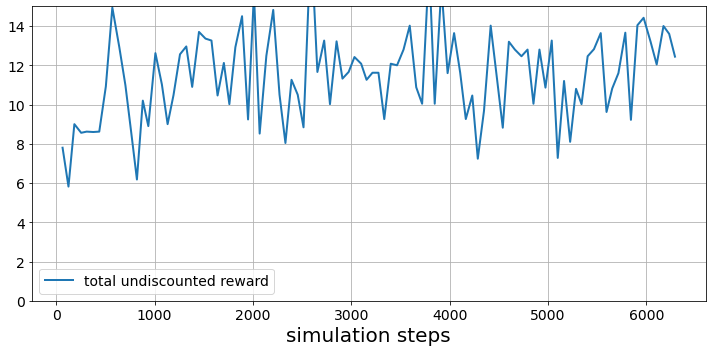

In [18]:
max_num_steps_per_ep = 10
num_eps_per_iter = 50
num_iters = 100
alpha = 0.1

actor = Actor(np.zeros((env.num_states, env.num_actions), dtype=np.float64))
optimizer_actor = torch.optim.SGD(actor.parameters(), lr=alpha)

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'r': [], 'w': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                s = s_prime
                if done:
                    break
            batch['s'].extend(traj['s'])
            batch['a'].extend(traj['a'])
            batch['r'].extend(traj['r'])
            batch['w'].extend([np.sum(traj['r'])] * len(traj['r']))
        batch['num_steps'] = len(batch['r'])
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['a'] = torch.tensor(batch['a'], requires_grad=False, dtype=torch.long)
        batch['r'] = torch.tensor(batch['r'], requires_grad=False, dtype=torch.double)
        batch['w'] = torch.tensor(batch['w'], requires_grad=False, dtype=torch.double)
    return batch

step = 0
data = {'step': [], 'reward': []}
for iter in range(num_iters):
    
    batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)
    
    with torch.no_grad():
        N = batch['r'].shape[0] / num_eps_per_iter
    
    optimizer_actor.zero_grad()
    logits = actor(batch['s'])
    dist = torch.distributions.categorical.Categorical(logits=logits)
    loss = - (N * dist.log_prob(batch['a']) * batch['w']).mean()
    loss.backward()
    optimizer_actor.step()
    
    step += batch['r'].shape[0]
    data['step'].append(step)
    data['reward'].append(batch['r'].mean() * N)
    
print(policy_as_string(actor))
plot_learning_curve(data)

Value function estimation with critic

In [19]:
max_num_steps_per_ep = 10
num_eps_per_iter = 50
num_iters = 10
alpha = 0.1

critic = Critic(np.zeros(env.num_states, dtype=np.float64))
optimizer_critic = torch.optim.SGD(critic.parameters(), lr=alpha)

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'V_target': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                s = s_prime
                if done:
                    break
            batch['s'].extend(traj['s'])
            # Target for value function is reward-to-go
            batch['V_target'].extend(np.flipud(np.flipud(traj['r']).cumsum()))
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['V_target'] = torch.tensor(batch['V_target'], requires_grad=False, dtype=torch.double)
    return batch

num_epochs_per_iter = 10
step = 0
print('  step : avg loss : V')
for iter in range(num_iters):
    batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)
    losses = []
    for epoch in range(num_epochs_per_iter):
        optimizer_critic.zero_grad()
        V = critic(batch['s'])
        loss = ((V - batch['V_target'])**2).mean() # <--- or... torch.nn.MSELoss()(V, batch['V_target'])
        with torch.no_grad():
            losses.append(loss.item())
        loss.backward()
        optimizer_critic.step()
    
    step += batch['V_target'].shape[0]
    print(f' {step:5d} : {np.mean(losses):8.2f} : [' + ','.join([f'{v:6.3f}' for v in critic.V.detach().numpy()]) + ']')

V = critic.V.detach().numpy()
print('')
print(f'V (est) : [' + ','.join([f'{v:6.3f}' for v in V]) + ']')

J_estimate = np.mean(V) # <-- assumes initial state is sampled uniformly at random
J_exact = payoff(actor.theta.detach().numpy(), max_num_steps)

print(f'payoff (exact) : {J_exact:6.3f} (truncated at {max_num_steps} steps)')
print(f'payoff (est)   : {J_estimate:6.3f} (from V estimate after {step} steps)')

  step : avg loss : V
    65 :   218.34 : [16.280, 1.392]
   121 :    96.20 : [17.378, 1.921]
   182 :   119.33 : [18.061, 2.656]
   244 :   108.53 : [18.373, 3.276]
   300 :    37.24 : [19.517, 1.880]
   364 :   287.60 : [20.605, 4.571]
   426 :    75.60 : [20.582, 4.518]
   483 :    61.12 : [19.312, 3.386]
   544 :   109.28 : [19.797, 4.134]
   607 :   105.49 : [19.940, 4.383]

V (est) : [19.940, 4.383]
payoff (exact) : 11.667 (truncated at 6 steps)
payoff (est)   : 12.161 (from V estimate after 607 steps)


Vanilla policy gradient with actor/critic and advantage estimation

policy for theta = [[ 2.805, -2.805], [-1.426,  1.426]]
 p(a_t = 0 | s_t = 0; theta) =  0.996
 p(a_t = 1 | s_t = 0; theta) =  0.004
 p(a_t = 0 | s_t = 1; theta) =  0.055
 p(a_t = 1 | s_t = 1; theta) =  0.945



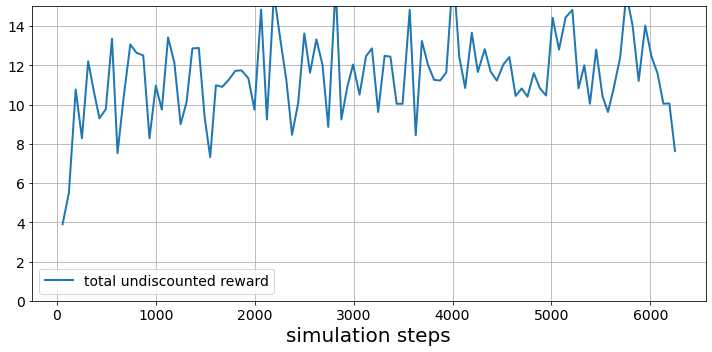

In [20]:
max_num_steps_per_ep = 10
num_eps_per_iter = 50
num_iters = 100
alpha = 0.1
gamm = 0.99
lamb = 0.95 # <--- cannot use "lambda" as a variable name in python code!

actor = Actor(np.zeros((env.num_states, env.num_actions), dtype=np.float64))
optimizer_actor = torch.optim.SGD(actor.parameters(), lr=alpha)

critic = Critic(np.zeros(env.num_states, dtype=np.float64))
optimizer_critic = torch.optim.SGD(critic.parameters(), lr=alpha)

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'r': [], 'w': [], 'V_target': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': [], 'V': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                traj['V'].append(critic(s).item())
                s = s_prime
                if done:
                    break
            
            # Get advantages and value targets
            # - get length of trajectory
            T = len(traj['r'])
            # - create copy of r and V, appended with zero (could append with bootstrap)
            r = np.append(traj['r'], 0.)
            V = np.append(traj['V'], 0.)
            # - compute deltas
            delta = r[:-1] + (gamm * V[1:]) - V[:-1]
            # - compute advantages as reversed, discounted, cumulative sum of deltas
            A = delta.copy()
            for t in reversed(range(T - 1)):
                A[t] = A[t] + (gamm * lamb * A[t + 1])
            # - get value targets
            for t in reversed(range(T)):
                V[t] = r[t] + (gamm * V[t + 1])
            V = V[:-1]
            
            batch['s'].extend(traj['s'])
            batch['a'].extend(traj['a'])
            batch['r'].extend(traj['r'])
            batch['w'].extend(A)
            batch['V_target'].extend(V)
        batch['num_steps'] = len(batch['r'])
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['a'] = torch.tensor(batch['a'], requires_grad=False, dtype=torch.long)
        batch['r'] = torch.tensor(batch['r'], requires_grad=False, dtype=torch.double)
        batch['w'] = torch.tensor(batch['w'], requires_grad=False, dtype=torch.double)
        batch['V_target'] = torch.tensor(batch['V_target'], requires_grad=False, dtype=torch.double)
    return batch

step = 0
data = {'step': [], 'reward': []}
for iter in range(num_iters):
    
    batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)
    
    with torch.no_grad():
        N = batch['r'].shape[0] / num_eps_per_iter
    
    # Actor optimization
    optimizer_actor.zero_grad()
    logits = actor(batch['s'])
    dist = torch.distributions.categorical.Categorical(logits=logits)
    loss = - (N * dist.log_prob(batch['a']) * batch['w']).mean()
    loss.backward()
    optimizer_actor.step()
    
    # Critic optimization
    optimizer_critic.zero_grad()
    V = critic(batch['s'])
    loss = ((V - batch['V_target'])**2).mean() # <--- or... torch.nn.MSELoss()(V, batch['V_target'])
    with torch.no_grad():
        losses.append(loss.item())
    loss.backward()
    optimizer_critic.step()
    
    step += batch['r'].shape[0]
    data['step'].append(step)
    data['reward'].append(batch['r'].mean() * N)
    
print(policy_as_string(actor))
plot_learning_curve(data)

Vanilla policy gradient with actor/critic and advantage estimation *and* importance sampling --- to see the difference in results with importance sampling (in such a simple example), look at the action probabilities and note that after the same number of simulation steps we have stronger convergence to the optimal policy

policy for theta = [[ 3.755, -3.755], [-2.629,  2.629]]
 p(a_t = 0 | s_t = 0; theta) =  0.999
 p(a_t = 1 | s_t = 0; theta) =  0.001
 p(a_t = 0 | s_t = 1; theta) =  0.005
 p(a_t = 1 | s_t = 1; theta) =  0.995



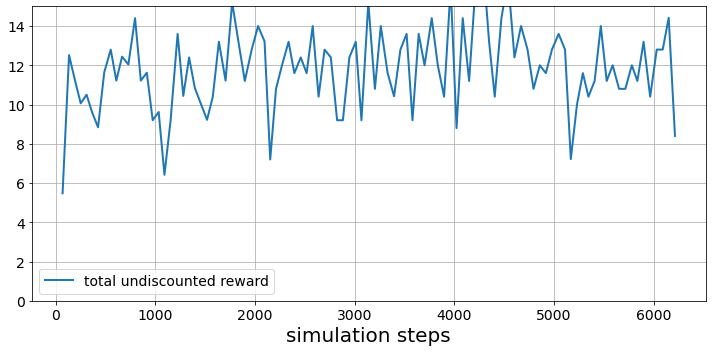

In [21]:
max_num_steps_per_ep = 10
num_eps_per_iter = 50
num_iters = 100
alpha = 0.1
gamm = 0.99
lamb = 0.95 # <--- cannot use "lambda" as a variable name in python code!
actor_epochs_per_iter = 10
critic_epochs_per_iter = 10

actor = Actor(np.zeros((env.num_states, env.num_actions), dtype=np.float64))
optimizer_actor = torch.optim.SGD(actor.parameters(), lr=alpha)

critic = Critic(np.zeros(env.num_states, dtype=np.float64))
optimizer_critic = torch.optim.SGD(critic.parameters(), lr=alpha)

def get_batch(num_eps, num_steps, actor):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'r': [], 'w': [], 'V_target': [], 'log_pi': []}
        for ep in range(num_eps):
            traj = {'s': [], 'a': [], 'r': [], 'V': [], 'log_pi': []}
            done = False
            s = env.reset()
            for step in range(num_steps):
                logits = actor(s)
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj['s'].append(s)
                traj['a'].append(a)
                traj['r'].append(r)
                traj['V'].append(critic(s).item())
                traj['log_pi'].append(dist.log_prob(torch.tensor(a))) # <--- for categorical distributions,
                                                                      #      must give log_prob a tensor
                s = s_prime
                if done:
                    break
            
            # Get advantages and value targets
            # - get length of trajectory
            T = len(traj['r'])
            # - create copy of r and V, appended with zero (could append with bootstrap)
            r = np.append(traj['r'], 0.)
            V = np.append(traj['V'], 0.)
            # - compute deltas
            delta = r[:-1] + (gamm * V[1:]) - V[:-1]
            # - compute advantages as reversed, discounted, cumulative sum of deltas
            A = delta.copy()
            for t in reversed(range(T - 1)):
                A[t] = A[t] + (gamm * lamb * A[t + 1])
            # - get value targets
            for t in reversed(range(T)):
                V[t] = r[t] + (gamm * V[t + 1])
            V = V[:-1]
            
            batch['s'].extend(traj['s'])
            batch['a'].extend(traj['a'])
            batch['r'].extend(traj['r'])
            batch['w'].extend(A)
            batch['V_target'].extend(V)
            batch['log_pi'].extend(traj['log_pi'])
        batch['num_steps'] = len(batch['r'])
        batch['s'] = torch.tensor(batch['s'], requires_grad=False, dtype=torch.long)
        batch['a'] = torch.tensor(batch['a'], requires_grad=False, dtype=torch.long)
        batch['r'] = torch.tensor(batch['r'], requires_grad=False, dtype=torch.double)
        batch['w'] = torch.tensor(batch['w'], requires_grad=False, dtype=torch.double)
        batch['V_target'] = torch.tensor(batch['V_target'], requires_grad=False, dtype=torch.double)
        batch['log_pi'] = torch.tensor(batch['log_pi'], requires_grad=False, dtype=torch.double)
    return batch

step = 0
data = {'step': [], 'reward': []}
for iter in range(num_iters):
    
    batch = get_batch(num_eps_per_iter, max_num_steps_per_ep, actor)
    
    with torch.no_grad():
        N = batch['r'].shape[0] / num_eps_per_iter
    
    # Actor optimization
    for epoch in range(actor_epochs_per_iter):
        optimizer_actor.zero_grad()
        logits = actor(batch['s'])
        dist = torch.distributions.categorical.Categorical(logits=logits)
        with torch.no_grad():
            log_pi = dist.log_prob(batch['a'])
            ratio = torch.exp(log_pi - batch['log_pi'])
        loss = - (N * dist.log_prob(batch['a']) * batch['w'] * ratio).mean()
        loss.backward()
        optimizer_actor.step()
    
    # Critic optimization
    for epoch in range(critic_epochs_per_iter):
        optimizer_critic.zero_grad()
        V = critic(batch['s'])
        loss = ((V - batch['V_target'])**2).mean() # <--- or... torch.nn.MSELoss()(V, batch['V_target'])
        with torch.no_grad():
            losses.append(loss.item())
        loss.backward()
        optimizer_critic.step()
    
    step += batch['r'].shape[0]
    data['step'].append(step)
    data['reward'].append(batch['r'].mean() * N)
    
print(policy_as_string(actor))
plot_learning_curve(data)